In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats 

%precision 4

'%.4f'

In [2]:
# rc('font', family='AppleGothic')
plt.rcParams["font.family"] = 'AppleGothic'
# plt.rcParams["font.size"] = 12

# 분산분석(ANalysis Of VAriance:ANOVA)

- 셋 이상의 그룹 간 차이가 존재하는지를 확인하기 위한 가설 검정 방법

### 가정
- 독립성 : 모든 그룹은 서로 독립적이어야 함
    - 각각의 모집단에서 표본은 독립적으로 추출되었다


- 정규성 : 모든 그룹의 데이터는 정규분포를 따라야 함


- 등분산성 : 모든 그룹에 데이터에 대한 분산이 같아야 함

### 예제1. plant data
- 세 가지 다른 조건에 자란 식물의 무게 비교

**가설**
- H0 : 세그룹의 표본평균은 같다
- H1 : 최소한 한 개 그룹에는 차이를 보인다

In [3]:
plants = pd.read_csv('data/plantGrowth.csv')
plants.head()

,weight,group
0,4.17,ctrl
1,5.58,ctrl
2,5.18,ctrl
3,6.11,ctrl
4,4.50,ctrl


In [4]:
plants.group.value_counts()

group
ctrl    10
trt1    10
trt2    10
Name: count, dtype: int64

In [5]:
plants.group.unique()

array(['ctrl', 'trt1', 'trt2'], dtype=object)

In [6]:
plants.describe()

,weight
count,30.000000
mean,5.073000
std,0.701192
min,3.590000
25%,4.550000
50%,5.155000
75%,5.530000
max,6.310000


In [7]:
plants.groupby(by='group').describe()

weight                                                    
       count   mean       std   min     25%    50%     75%   max
group                                                           
ctrl    10.0  5.032  0.583091  4.17  4.5500  5.155  5.2925  6.11
trt1    10.0  4.661  0.793676  3.59  4.2075  4.550  4.8700  6.03
trt2    10.0  5.526  0.442573  4.92  5.2675  5.435  5.7350  6.31

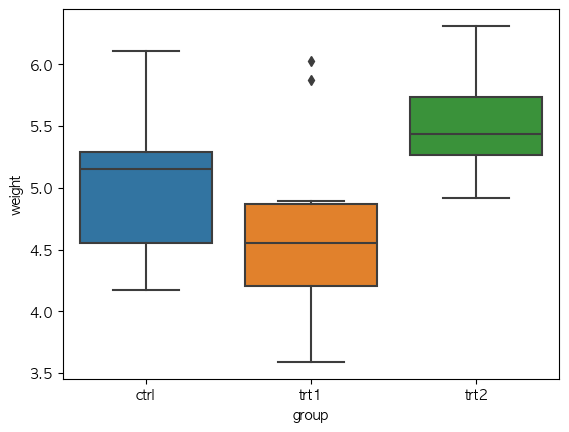

In [8]:
sns.boxplot(data=plants, x='group', y='weight')
plt.show()

### 1) 정규성 검정
- shapiro-wilk test

In [9]:
ctrl = plants[plants.group=='ctrl'].weight
trt1 = plants[plants.group=='trt1'].weight
trt2 = plants[plants.group=='trt2'].weight

In [10]:
print(stats.shapiro(ctrl))
print(stats.shapiro(trt1))
print(stats.shapiro(trt2))

ShapiroResult(statistic=0.9566816687583923, pvalue=0.747475802898407)
ShapiroResult(statistic=0.9304107427597046, pvalue=0.4519447386264801)
ShapiroResult(statistic=0.9410051703453064, pvalue=0.5642521977424622)


=> 정규성 가정 만족함

### 2) 등분산성 검정
- Levene Test

In [11]:
stats.levene(ctrl, trt1, trt2)

LeveneResult(statistic=1.1191856948703909, pvalue=0.3412266241254737)

=> 세 그룹의 분산은 같다 (등분산성 만족)

### 3) 분산분석을 위한 모듈과 함수

#### ① scipy.stats 모듈 : f_oneway()
- https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.f_oneway.html

In [12]:
stats.f_oneway(ctrl, trt1, trt2)

F_onewayResult(statistic=4.846087862380136, pvalue=0.0159099583256229)

#### ② statsmodels 패키지 : ols(), anova_lm()
- https://www.statsmodels.org/stable/generated/statsmodels.formula.api.ols.html#statsmodels.formula.api.ols
- https://www.statsmodels.org/stable/generated/statsmodels.stats.anova.anova_lm.html

In [13]:
import statsmodels
statsmodels.__version__

'0.14.0'

In [14]:
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm

In [15]:
model = ols('weight~C(group)', plants).fit()
anova_lm(model)

,df,sum_sq,mean_sq,F,PR(>F)
C(group),2.0,3.76634,1.883170,4.846088,0.01591
Residual,27.0,10.49209,0.388596,NaN,NaN


### 사후분석
- 그룹간 평균이 차이가 있는 경우, 어떤 그룹들이 차이가 있는지 검정
- Tukey's HSD, Bonferroni 방법
- statsmodels.sandbox.stats.multicomp.MultiComparison()
    - https://www.statsmodels.org/dev/generated/statsmodels.sandbox.stats.multicomp.MultiComparison.html

- Bonferroni test

In [16]:
from statsmodels.sandbox.stats.multicomp import MultiComparison

In [17]:
comp = MultiComparison(plants.weight, plants.group)
result = comp.allpairtest(stats.ttest_ind, method='bonf')
result[0]

group1,group2,stat,pval,pval_corr,reject
ctrl,trt1,1.1913,0.249,0.7471,False
ctrl,trt2,-2.134,0.0469,0.1406,False
trt1,trt2,-3.0101,0.0075,0.0226,True


- Tukey's HSD test

In [18]:
from statsmodels.stats.multicomp import pairwise_tukeyhsd

In [19]:
hsd = pairwise_tukeyhsd(plants.weight, plants.group, alpha=0.05)

In [20]:
hsd.summary()

group1,group2,meandiff,p-adj,lower,upper,reject
ctrl,trt1,-0.371,0.3909,-1.0622,0.3202,False
ctrl,trt2,0.494,0.198,-0.1972,1.1852,False
trt1,trt2,0.865,0.012,0.1738,1.5562,True


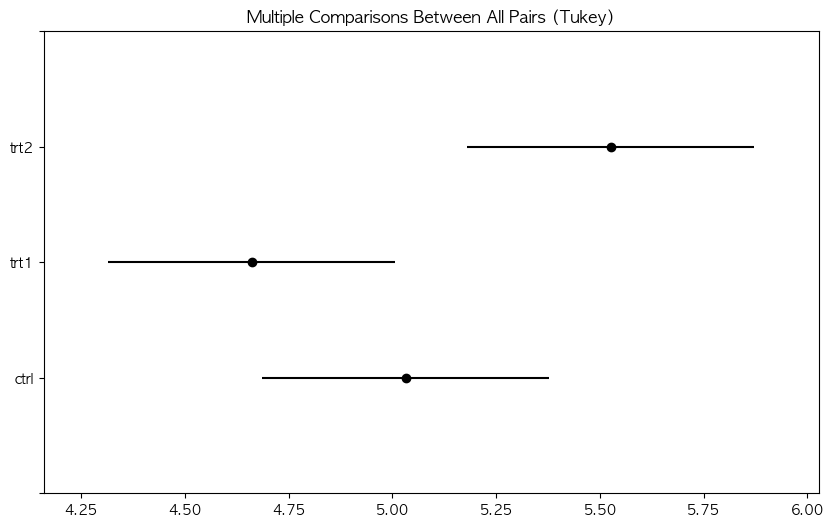

In [21]:
fig = hsd.plot_simultaneous()

### 예제2. iris data
- 품종에 따라 꽃받침의 너비(sepal_width)의 평균이 다른가?

In [22]:
iris = sns.load_dataset('iris')
iris.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   sepal_length  150 non-null    float64
 1   sepal_width   150 non-null    float64
 2   petal_length  150 non-null    float64
 3   petal_width   150 non-null    float64
 4   species       150 non-null    object 
dtypes: float64(4), object(1)
memory usage: 6.0+ KB


In [23]:
#품종별 sepal_width 데이터 생성
setosa = iris.sepal_width[iris.species =='setosa']
versicolor = iris.sepal_width[iris.species =='versicolor']
virginica = iris.sepal_width[iris.species =='virginica']

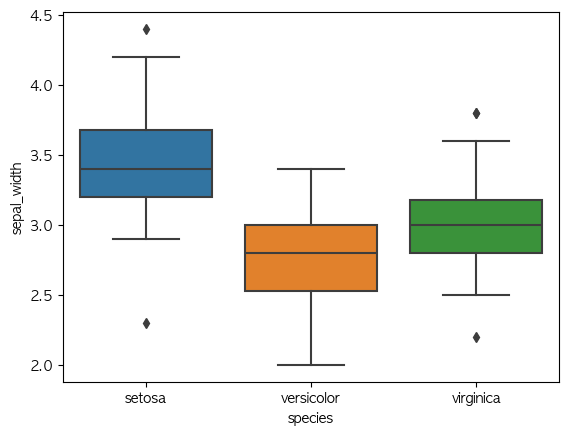

In [24]:
sns.boxplot(data=iris, x='species', y='sepal_width')
plt.show()

#### 정규성 검정

In [25]:
print(stats.shapiro(setosa))
print(stats.shapiro(versicolor))
print(stats.shapiro(virginica))

ShapiroResult(statistic=0.971718966960907, pvalue=0.2715126574039459)
ShapiroResult(statistic=0.9741330742835999, pvalue=0.33798879384994507)
ShapiroResult(statistic=0.9673907160758972, pvalue=0.18089857697486877)


=> 품종별 꽃받침 너비 자료는 정규분포를 따름

#### 등분산성 검정

- Levene test

In [26]:
stats.levene(setosa, versicolor, virginica)

LeveneResult(statistic=0.5902115655853319, pvalue=0.5555178984739075)

- Bartlette test

In [27]:
stats.bartlett(setosa, versicolor, virginica)

BartlettResult(statistic=2.0910752014391774, pvalue=0.35150280041581317)

#### 일원분산분석 수행

In [28]:
stats.f_oneway(setosa, versicolor, virginica)

F_onewayResult(statistic=49.160040089612075, pvalue=4.492017133309115e-17)

In [29]:
model = ols('sepal_width ~ C(species)', data=iris).fit()
anova_lm(model)

,df,sum_sq,mean_sq,F,PR(>F)
C(species),2.0,11.344933,5.672467,49.16004,4.492017e-17
Residual,147.0,16.962000,0.115388,NaN,NaN


#### 사후검정

- Bonferroni test

In [30]:
comp = MultiComparison(iris.sepal_width, iris.species)
result = comp.allpairtest(stats.ttest_ind, method='bonf')
result[0]

group1,group2,stat,pval,pval_corr,reject
setosa,versicolor,9.455,0.0,0.0,True
setosa,virginica,6.4503,0.0,0.0,True
versicolor,virginica,-3.2058,0.0018,0.0055,True


- Tukey's HSD test

In [31]:
hsd = pairwise_tukeyhsd(iris.sepal_width, iris.species)
hsd.summary()

group1,group2,meandiff,p-adj,lower,upper,reject
setosa,versicolor,-0.658,0.0,-0.8189,-0.4971,True
setosa,virginica,-0.454,0.0,-0.6149,-0.2931,True
versicolor,virginica,0.204,0.0088,0.0431,0.3649,True


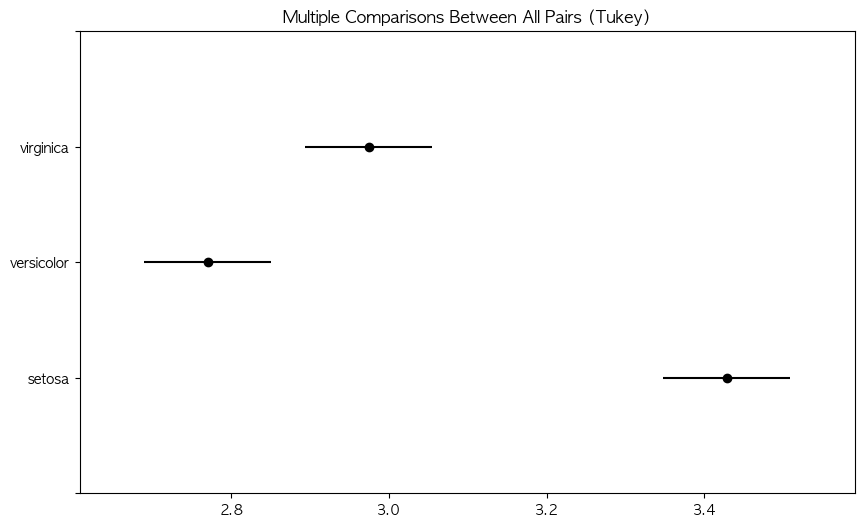

In [32]:
fig = hsd.plot_simultaneous() #겹치는게 없음

### 일원분산분석에서 가정을 만족하지 않는 경우

#### 1) 정규성 만족하지 않는 경우 

- 크루스칼 왈리스 검정(Kruskal-Wallis Test)

- 함수형식: scipy.stats.kruskal(*samples, nan_policy='propagate', axis=0, keepdims=False)
    - https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.kruskal.html

#### 2) 등분산성 만족하지 않는 경우
- Brown-Forsythe 또는 Welch 검정을 통해 분석
- Welch-test
    - https://pingouin-stats.org/generated/pingouin.welch_anova.html
    - 패키지 다운로드 및 설치(https://pingouin-stats.org/index.html)
    - [명령어] conda install -c conda-forge pingouin

### 예제. 편의점
- 세 편의점에 대한 소비자 만족도에 차이가 있는가?

In [33]:
data = pd.read_csv('data/편의점만족도.csv', encoding='euc-kr')
data

,고객ID,편의점A,편의점B,편의점C
0,1,1.0,4.0,4
1,2,4.0,4.0,3
2,3,3.0,3.0,4
3,4,3.0,4.0,3
4,5,3.0,4.0,4
5,6,3.0,5.0,4
6,7,3.0,4.0,3
7,8,NaN,4.0,3
8,9,NaN,NaN,3


In [34]:
data.describe()

,고객ID,편의점A,편의점B,편의점C
count,9.000000,7.000000,8.000000,9.000000
mean,5.000000,2.857143,4.000000,3.444444
std,2.738613,0.899735,0.534522,0.527046
min,1.000000,1.000000,3.000000,3.000000
25%,3.000000,3.000000,4.000000,3.000000
50%,5.000000,3.000000,4.000000,3.000000
75%,7.000000,3.000000,4.000000,4.000000
max,9.000000,4.000000,5.000000,4.000000


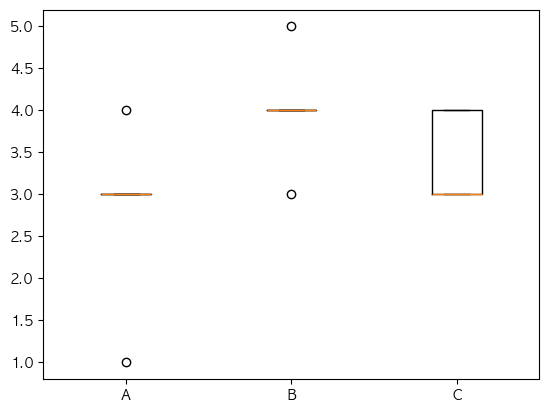

In [35]:
a = data.편의점A.dropna()
b = data.편의점B.dropna()
c = data.편의점C.dropna()

plt.boxplot([a,b,c])
plt.xticks([1,2,3],['A','B','C'])
plt.show()

#### wide form -> long form : 
- statsmodel에서 제공하는 ols() 사용하여 분산분석 수행 시
    - 그룹별 데이터가 컬럼으로 이루어진 wide form data인 경우
    - 그룹들이 하나의 컬럼을 갖도록 long form으로 변경해야 한다.

In [36]:
data2 = pd.DataFrame({'score':pd.concat([a,b,c]),
              'store':['A']*len(a)+['B']*len(b) +['C']*len(c)})
data2

,score,store
0,1.0,A
1,4.0,A
2,3.0,A
3,3.0,A
4,3.0,A
5,3.0,A
6,3.0,A
0,4.0,B
1,4.0,B
2,3.0,B


#### 정규성 검정
- shapiro-wilk test 수행

In [37]:
print(stats.shapiro(a))
print(stats.shapiro(b))
print(stats.shapiro(c))

ShapiroResult(statistic=0.7194244265556335, pvalue=0.0060172914527356625)
ShapiroResult(statistic=0.7321971654891968, pvalue=0.005180804990231991)
ShapiroResult(statistic=0.6547360420227051, pvalue=0.00041939259972423315)


**=> 데이터가 정규성을 모두 만족하지 않으므로 크루스칼-왈리스 검정 수행**

In [38]:
stats.kruskal(a,b,c)

KruskalResult(statistic=8.750078938385395, pvalue=0.012587645408427016)

[결론] H0 기각: 세 편의점에 대한 만족도는 차이가 있다.

#### 참고.

In [39]:
model = ols('score ~ C(store)', data2).fit()
anova_lm(model)

,df,sum_sq,mean_sq,F,PR(>F)
C(store),2.0,4.878968,2.439484,5.642373,0.010935
Residual,21.0,9.079365,0.432351,NaN,NaN


#### 등분산성을 만족하지 않는 경우: Welch ANOVA

In [40]:
# pip install pingouin

In [41]:
import pingouin

In [42]:
from pingouin import welch_anova, read_dataset

In [43]:
df = read_dataset('anova')
df

,Subject,Hair color,Pain threshold
0,1,Light Blond,62
1,2,Light Blond,60
2,3,Light Blond,71
3,4,Light Blond,55
4,5,Light Blond,48
5,6,Dark Blond,63
6,7,Dark Blond,57
7,8,Dark Blond,52
8,9,Dark Blond,41
9,10,Dark Blond,43


In [44]:
df.describe()

,Subject,Pain threshold
count,19.000000,19.000000
mean,10.000000,47.842105
std,5.627314,11.456503
min,1.000000,30.000000
25%,5.500000,40.000000
50%,10.000000,48.000000
75%,14.500000,56.000000
max,19.000000,71.000000


In [45]:
df.groupby(by='Hair color').describe()

Subject                                                  \
                 count  mean       std   min    25%   50%    75%   max   
Hair color                                                               
Dark Blond         5.0   8.0  1.581139   6.0   7.00   8.0   9.00  10.0   
Dark Brunette      5.0  17.0  1.581139  15.0  16.00  17.0  18.00  19.0   
Light Blond        5.0   3.0  1.581139   1.0   2.00   3.0   4.00   5.0   
Light Brunette     4.0  12.5  1.290994  11.0  11.75  12.5  13.25  14.0   

               Pain threshold                                                
                        count  mean       std   min   25%   50%   75%   max  
Hair color                                                                   
Dark Blond                5.0  51.2  9.284396  41.0  43.0  52.0  57.0  63.0  
Dark Brunette             5.0  37.4  8.324662  30.0  32.0  35.0  39.0  51.0  
Light Blond               5.0  59.2  8.526429  48.0  55.0  60.0  62.0  71.0  
Light Brunette            4.0  42.5  5.446712  37.0  40.0  41.5  44.0  50.0

In [46]:
df.groupby(by='Hair color')['Pain threshold'].agg(stats.shapiro)

Hair color
Dark Blond         (0.9397903680801392, 0.6644565463066101)
Dark Brunette     (0.8832138776779175, 0.32412922382354736)
Light Blond        (0.9910322427749634, 0.9831817150115967)
Light Brunette       (0.930607259273529, 0.597973108291626)
Name: Pain threshold, dtype: object

In [47]:
dbl = df[df['Hair color'] == 'Dark Blond']['Pain threshold']
lbl = df[df['Hair color'] == 'Light Blond']['Pain threshold']
dbr = df[df['Hair color'] == 'Dark Brunette']['Pain threshold']
lbr = df[df['Hair color'] == 'Light Brunette']['Pain threshold']

stats.levene(dbl, lbl, dbr, lbr)

LeveneResult(statistic=0.39274322169059017, pvalue=0.7600161269687682)

In [48]:
welch_anova(dv='Pain threshold', between='Hair color', data=df)

,Source,ddof1,ddof2,F,p-unc,np2
0,Hair color,3,8.329841,5.890115,0.018813,0.575962


#### 문제


iris 데이터셋에서 꽃잎길이(petal_length)가 품종에 따라 차이가 있다고 말할 수 있는지 가설검정하시오.

- 데이터 파악/시각화

In [49]:
iris = sns.load_dataset('iris')
iris.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   sepal_length  150 non-null    float64
 1   sepal_width   150 non-null    float64
 2   petal_length  150 non-null    float64
 3   petal_width   150 non-null    float64
 4   species       150 non-null    object 
dtypes: float64(4), object(1)
memory usage: 6.0+ KB


In [50]:
iris.species.unique()

array(['setosa', 'versicolor', 'virginica'], dtype=object)

In [51]:
setosa = iris[iris['species']=='setosa'].petal_length
versicolor = iris[iris['species']=='versicolor'].petal_length
virginica = iris[iris['species']=='virginica'].petal_length

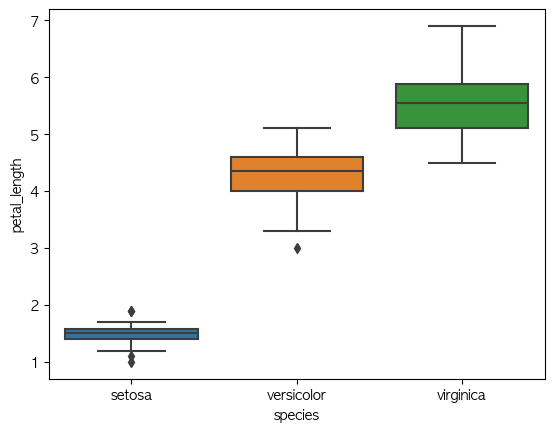

In [52]:
# 품종별 petal_length 데이터 생성
setosa_p=iris.petal_length[iris.species=='setosa']
versicolor_p=iris.petal_length[iris.species=='versicolor']
virginica_p=iris.petal_length[iris.species=='virginica']
# 시각화
sns.boxplot(data=iris,x='species',y='petal_length')
plt.show()

In [53]:
iris.groupby(by='species')['petal_length'].describe()

,count,mean,std,min,25%,50%,75%,max
species,,,,,,,,
setosa,50.0,1.462,0.173664,1.0,1.4,1.50,1.575,1.9
versicolor,50.0,4.260,0.469911,3.0,4.0,4.35,4.600,5.1
virginica,50.0,5.552,0.551895,4.5,5.1,5.55,5.875,6.9


- 정규성 검정

In [54]:
iris.groupby(by='species')['petal_length'].agg(stats.shapiro)

species
setosa        (0.9549766182899475, 0.05481043830513954)
versicolor     (0.966004490852356, 0.15847867727279663)
virginica     (0.9621864557266235, 0.10977503657341003)
Name: petal_length, dtype: object

- 등분산성 검정

In [55]:
setosa = iris[iris['species']=='setosa']['petal_length']
versicolor = iris[iris['species']=='versicolor']['petal_length']
virginica = iris[iris['species']=='virginica']['petal_length']

stats.levene(setosa, versicolor, virginica)
#등분산이 아님

LeveneResult(statistic=19.480338801923573, pvalue=3.1287566394085344e-08)

- 분산분석 수행

In [56]:
welch_anova(dv='petal_length', between='species', data=iris)

,Source,ddof1,ddof2,F,p-unc,np2
0,species,2,78.072955,1828.091945,2.693327e-66,0.941372


- 사후 검정

In [ ]:
# Bonferroni test
comp = MultiComparison(iris.petal_length, iris.species)
result = comp.allpairtest(stats.ttest_ind, method='bonf')
result[0]

In [57]:
# Tukey's HSD test
hsd = pairwise_tukeyhsd(iris.petal_length, iris.species)
hsd.summary()

group1,group2,meandiff,p-adj,lower,upper,reject
setosa,versicolor,2.798,0.0,2.5942,3.0018,True
setosa,virginica,4.09,0.0,3.8862,4.2938,True
versicolor,virginica,1.292,0.0,1.0882,1.4958,True


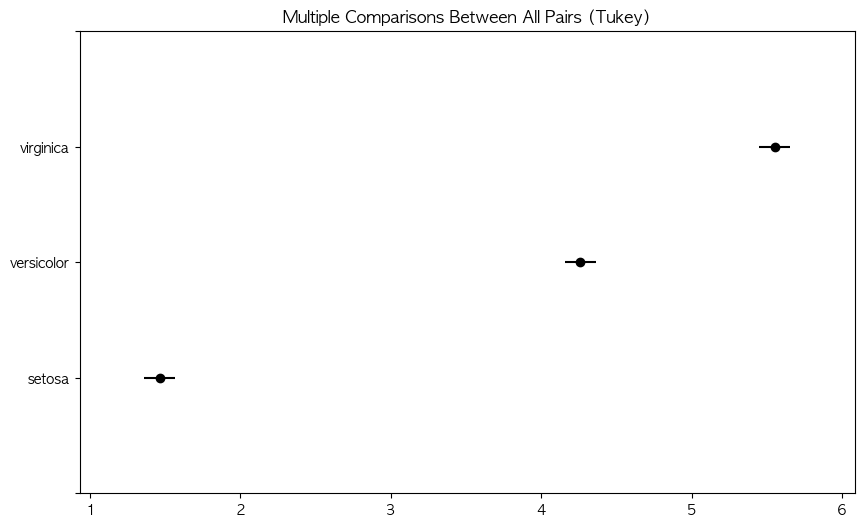

In [58]:
fig = hsd.plot_simultaneous()

참고 블로그 : https://velog.io/@pyose95/Data-Analysis

----------------------------------------------------